In [620]:
import os
import sys
import urllib, io
import pickle

import numpy as np
import scipy.stats as stats
import pandas as pd

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 
from IPython.core.display import HTML 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [575]:
experiment_name = 'zipping'

## directory & file hierarchy
proj_dir = os.path.abspath('../..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))
results_dir = os.path.join(proj_dir,'results')

# paths specific to this experiment
experiment_results_dir = os.path.join(results_dir, experiment_name)
plot_dir = os.path.join(experiment_results_dir,'plots')
csv_dir = os.path.join(experiment_results_dir,'csv')
json_dir = os.path.join(experiment_results_dir,'json')

png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))
jefan_dir = os.path.join(analysis_dir,'jefan')
will_dir = os.path.join(analysis_dir,'will')

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

In [576]:
# set vars 
auth = pd.read_csv(os.path.join(proj_dir, 'auth.txt'), header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['block_construction']
coll = db['zipping']

# which iteration name should we use?
iteration_name = 'pilot_0'
iteration_names = [iteration_name]

# variables to check integrity of data
# numTrials = 8

In [577]:
query = coll.find()
df_all = pd.DataFrame(query)
df_all.iterationName.unique()

array(['zipping_prepilot', 'zipping_dev', 'pilot_0', 'pilot_debug'],
      dtype=object)

In [578]:
query = coll.find({"$and":[
                        {'trial_type':'survey-text'},
#                         {'eventType':'trialEnd'},
                        {'iterationName': { '$in': iteration_names }}, #use this if one iteration name
#                         {'prolificPID': '5b681e2c7a68ea0001ca7f08'}]
                        ]})
df_survey = pd.DataFrame(query)
df_survey

,_id,rt,response,trial_type,trial_index,time_elapsed,internal_node_id,datatype,experimentName,iterationName,workerID,gameID
0,61686dfba4fd036b5f7100b4,29159.9,{'Q0': ''},survey-text,2,97119,0.0-2.0,trial_end,block_construction_zipping,pilot_0,6166d1c6e7040ea1ea988e96,2279-c88a3b06-2963-4e58-ac7c-d4bcc6709de9
1,61686f27a4fd036b5f7100b8,18749.6,{'Q0': ''},survey-text,2,186944,0.0-2.0,trial_end,block_construction_zipping,pilot_0,615e48dc30648688abd794f9,3158-139c70ae-2db8-4e2a-81ae-470823afefbf
2,61686f8aa4fd036b5f7100ba,9579.6,{'Q0': ''},survey-text,2,149950,0.0-2.0,trial_end,block_construction_zipping,pilot_0,5dcf61c0ffc3d80a11037cb7,9490-2239c1aa-11a1-4375-a7ae-c074c5d0ab4d
3,6168734ca4fd036b5f7100be,10202.7,{'Q0': ''},survey-text,2,71499,0.0-2.0,trial_end,block_construction_zipping,pilot_0,615e7e56a9e06f23d68f5480,6579-8c65b7ac-efd2-4473-a9f3-e956eef4a62b
4,61687379a4fd036b5f7100c0,4674.8,{'Q0': ''},survey-text,2,66502,0.0-2.0,trial_end,block_construction_zipping,pilot_0,61673f4db274850873e4fbb6,0046-f3154684-b0b8-4679-8b92-c67d6b84cc7f


In [579]:
query = coll.find({"$and":[
                        {'trial_type':'block-construction'},
#                         {'eventType':'trialEnd'},
                        {'iterationName': { '$in': iteration_names }}, #use this if one iteration name
#                         {'prolificPID': '5b681e2c7a68ea0001ca7f08'}]
                        ]})
df_build = pd.DataFrame(query)
df_build

,_id,timeAbsolute,timeRelative,blocks,discreteWorld,eventType,endReason,stimURL,stimulus,stimId,...,chunk_type,trial_type,trial_index,time_elapsed,internal_node_id,datatype,experimentName,iterationName,workerID,gameID
0,61678ec99075de37027a1f30,1.634177e+12,159336,"[{'x': 4, 'y': 0, 'width': 1, 'height': 2}, {'...","[[True, True, True, True, True, True, True, Tr...",trial_end,perfect-reconstruction-translation,https://lax-tower-4-block-unique-silhouettes-j...,"{'blocks': [{'x': 0, 'y': 0, 'height': 2, 'wid...",127,...,tall,block-construction,2,157819,0.0-2.0,trial_end,block_construction_zipping,pilot_0,61678071de3b5fb66dd56f43,6077-f23a7e61-5a66-4da1-9d16-9a0ae3df945e
1,61678ee79075de37027a1f31,1.634177e+12,188614,"[{'x': 4, 'y': 0, 'width': 2, 'height': 1}, {'...","[[True, True, True, True, True, True, True, Tr...",trial_end,perfect-reconstruction-translation,https://lax-tower-4-block-unique-silhouettes-j...,"{'blocks': [{'x': 0, 'y': 0, 'height': 1, 'wid...",011,...,wide,block-construction,3,187097,0.0-3.0,trial_end,block_construction_zipping,pilot_0,61678071de3b5fb66dd56f43,6077-f23a7e61-5a66-4da1-9d16-9a0ae3df945e
2,61678ef79075de37027a1f32,1.634177e+12,204920,"[{'x': 5, 'y': 0, 'width': 1, 'height': 2}, {'...","[[True, True, True, True, True, True, True, Tr...",trial_end,perfect-reconstruction-translation,https://lax-tower-4-block-unique-silhouettes-j...,"{'blocks': [{'x': 0, 'y': 0, 'height': 2, 'wid...",122,...,tall,block-construction,4,203403,0.0-4.0,trial_end,block_construction_zipping,pilot_0,61678071de3b5fb66dd56f43,6077-f23a7e61-5a66-4da1-9d16-9a0ae3df945e
3,61678f109075de37027a1f33,1.634177e+12,230061,"[{'x': 4, 'y': 0, 'width': 1, 'height': 2}, {'...","[[True, True, True, True, True, True, True, Tr...",trial_end,perfect-reconstruction-translation,https://lax-tower-4-block-unique-silhouettes-j...,"{'blocks': [{'x': 0, 'y': 0, 'height': 2, 'wid...",024,...,wide,block-construction,5,228544,0.0-5.0,trial_end,block_construction_zipping,pilot_0,61678071de3b5fb66dd56f43,6077-f23a7e61-5a66-4da1-9d16-9a0ae3df945e
4,61678f249075de37027a1f34,1.634177e+12,250489,"[{'x': 5, 'y': 0, 'width': 1, 'height': 2}, {'...","[[True, True, True, True, True, True, True, Tr...",trial_end,perfect-reconstruction-translation,https://lax-tower-4-block-unique-silhouettes-j...,"{'blocks': [{'x': 0, 'y': 0, 'height': 2, 'wid...",122,...,tall,block-construction,6,248973,0.0-6.0,trial_end,block_construction_zipping,pilot_0,61678071de3b5fb66dd56f43,6077-f23a7e61-5a66-4da1-9d16-9a0ae3df945e
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,6168963e20153c3569fefe61,1.634244e+12,297161,"[{'x': 4, 'y': 0, 'width': 1, 'height': 2}, {'...","[[True, True, True, True, True, True, True, Tr...",trial_end,perfect-reconstruction-translation,https://lax-tower-4-block-unique-silhouettes-j...,"{'blocks': [{'x': 0, 'y': 0, 'height': 2, 'wid...",102,...,tall,block-construction,2,287895,0.0-2.0,trial_end,block_construction_zipping,pilot_0,616724519e164a78a095b4a6,8529-e9d417cc-6235-446a-a9b9-a12e9c32671d
129,6168964120153c3569fefe64,1.634244e+12,300613,"[{'x': 4, 'y': 0, 'width': 1, 'height': 2}, {'...","[[True, True, True, True, True, True, True, Tr...",trial_end,perfect-reconstruction-translation,https://lax-tower-4-block-unique-silhouettes-j...,"{'blocks': [{'x': 0, 'y': 0, 'height': 2, 'wid...",122,...,tall,block-construction,2,298637,0.0-2.0,trial_end,block_construction_zipping,pilot_0,615375a2fd9b41728babd98a,1800-045c1297-53e9-4de1-8923-ad408830be53
130,6168964b20153c3569fefe72,1.634244e+12,310363,"[{'x': 3, 'y': 0, 'width': 1, 'height': 2}, {'...","[[True, True, True, True, True, True, True, Tr...",trial_end,perfect-reconstruction-translation,https://lax-tower-4-block-unique-silhouettes-j...,"{'blocks': [{'x': 0, 'y': 0, 'height': 2, 'wid...",025,...,wide,block-construction,3,301097,0.0-3.0,trial_end,block_construction_zipping,pilot_0,616724519e164a78a095b4a6,8529-e9d417cc-6235-446a-a9b9-a12e9c32671d
131,616896522015

In [787]:
query = coll.find({"$and":[
                        {'trial_type':'tower-zipping'},
#                         {'eventType':'trialEnd'},
                        {'iterationName': { '$in': iteration_names}}, #use this if one iteration name
#                         {'prolificPID': '5b681e2c7a68ea0001ca7f08'}]
                        ]})
df_zip = pd.DataFrame(query)
df_zip

,_id,rt,stimulus,response,response_correct,stimURL,chunk_id,rep,block_number,composite_duration,...,compatible_condition,trial_type,trial_index,time_elapsed,internal_node_id,datatype,experimentName,iterationName,workerID,gameID
0,61678fd99075de37027a1f43,2155.4,https://tower-4-block-unique-silhouettes-compo...,m,1,https://tower-4-block-unique-silhouettes-compo...,wides_025_023,0,0,500,...,none,tower-zipping,21,429898,0.0-21.0,trial_end,block_construction_zipping,pilot_0,61678071de3b5fb66dd56f43,6077-f23a7e61-5a66-4da1-9d16-9a0ae3df945e
1,61678fdc9075de37027a1f44,993.8,https://tower-4-block-unique-silhouettes-compo...,z,1,https://tower-4-block-unique-silhouettes-compo...,wides_025_023,0,0,500,...,none,tower-zipping,22,432698,0.0-22.0,trial_end,block_construction_zipping,pilot_0,61678071de3b5fb66dd56f43,6077-f23a7e61-5a66-4da1-9d16-9a0ae3df945e
2,61678fe09075de37027a1f45,1558.3,https://tower-4-block-unique-silhouettes-compo...,m,1,https://tower-4-block-unique-silhouettes-compo...,wides_025_023,0,0,500,...,B,tower-zipping,23,436072,0.0-23.0,trial_end,block_construction_zipping,pilot_0,61678071de3b5fb66dd56f43,6077-f23a7e61-5a66-4da1-9d16-9a0ae3df945e
3,61678fe29075de37027a1f46,989.6,https://tower-4-block-unique-silhouettes-compo...,z,1,https://tower-4-block-unique-silhouettes-compo...,wides_025_023,0,0,500,...,none,tower-zipping,24,438927,0.0-24.0,trial_end,block_construction_zipping,pilot_0,61678071de3b5fb66dd56f43,6077-f23a7e61-5a66-4da1-9d16-9a0ae3df945e
4,61678fe59075de37027a1f47,983.6,https://tower-4-block-unique-silhouettes-compo...,m,0,https://tower-4-block-unique-silhouettes-compo...,wides_025_023,0,0,500,...,B,tower-zipping,25,441608,0.0-25.0,trial_end,block_construction_zipping,pilot_0,61678071de3b5fb66dd56f43,6077-f23a7e61-5a66-4da1-9d16-9a0ae3df945e
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,6168995820153c3569ff005b,1600.5,https://tower-4-block-unique-silhouettes-compo...,z,1,https://tower-4-block-unique-silhouettes-compo...,wides_025_023,3,2,1000,...,B,tower-zipping,164,1089651,0.0-164.0,trial_end,block_construction_zipping,pilot_0,615375a2fd9b41728babd98a,1800-045c1297-53e9-4de1-8923-ad408830be53
1436,6168995c20153c3569ff005c,1513.9,https://tower-4-block-unique-silhouettes-compo...,m,1,https://tower-4-block-unique-silhouettes-compo...,wides_025_023,3,2,1000,...,B,tower-zipping,165,1093630,0.0-165.0,trial_end,block_construction_zipping,pilot_0,615375a2fd9b41728babd98a,1800-045c1297-53e9-4de1-8923-ad408830be53
1437,6168996020153c3569ff005d,1524.9,https://tower-4-block-unique-silhouettes-compo...,z,1,https://tower-4-block-unique-silhouettes-compo...,wides_025_023,3,2,1000,...,none,tower-zipping,166,1097730,0.0-166.0,trial_end,block_construction_zipping,pilot_0,615375a2fd9b41728babd98a,1800-045c1297-53e9-4de1-8923-ad408830be53
1438,6168996420153c3569ff005e,1742.7,https://tower-4-block-unique-silhouettes-compo...,z,1,https://tower-4-block-unique-silhouettes-compo...,wides_025_023,3,2,1000,...,A,tower-zipping,167,1101901,0.0-167.0,trial_end,block_construction_zipping,pilot_0,615375a2fd9b41728babd98a,1800-045c1297-53e9-4de1-8923-ad408830be53


In [788]:
df_zip['compatibility'] = 'none'
df_zip.loc[df_zip.compatible_condition == df_zip.participant_condition, 'compatibility'] = 'compatible'
df_zip.loc[df_zip.compatible_condition != df_zip.participant_condition,'compatibility'] = 'incompatible'
df_zip.loc[df_zip.compatible_condition == 'none','compatibility'] = 'novel'

In [789]:
df_zip['composite_id'] = df_zip['stimulus'].apply(lambda url: url.split('composites_silhouette_')[1])

In [790]:
df_zip.loc[:,'trial_bin'] = np.round(df_zip.trial_index/12)

In [791]:
df_zip.loc[:,'flagRT'] = False
df_zip.loc[(df_zip.rt > 5000), 'flagRT'] = True

In [793]:
p = df_zip.groupby('gameID').response_correct.mean() > 0.65
ppt_greater_chance = list(p[p].index)
df_zip = df_zip[df_zip.gameID.isin(ppt_greater_chance)].reset_index()

In [802]:
df_zip.to_csv('zipping_pilot_1.csv')

In [803]:
df_zip = pd.read_csv('zipping_pilot_1.csv')

### plot setup

In [804]:
sns.set_context('poster')
sns.set(font_scale=1.2)
sns.set_style('whitegrid', {'font.family':'sans-serif', 'font.sans-serif':'Avenir'})

### accuracy

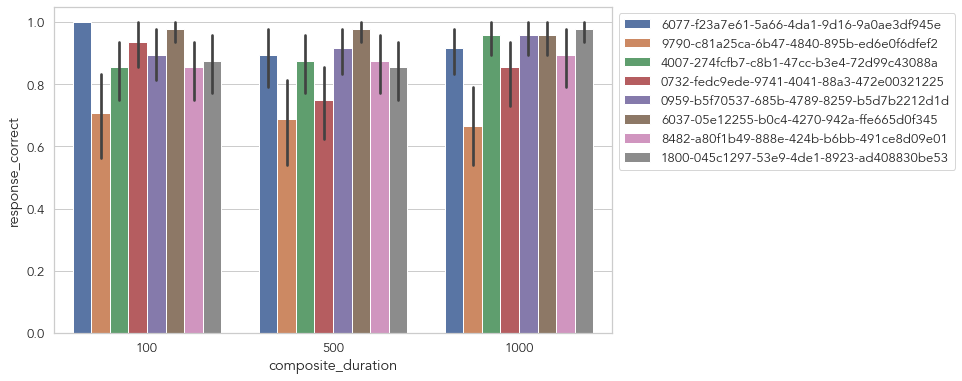

In [805]:
fig = plt.figure(figsize=(10,6))

sns.barplot(data=df_zip, 
              y="response_correct", 
              x="composite_duration",
              hue="gameID")
plt.legend(bbox_to_anchor=(1.0,1))

## Compatibility

### Accuracy

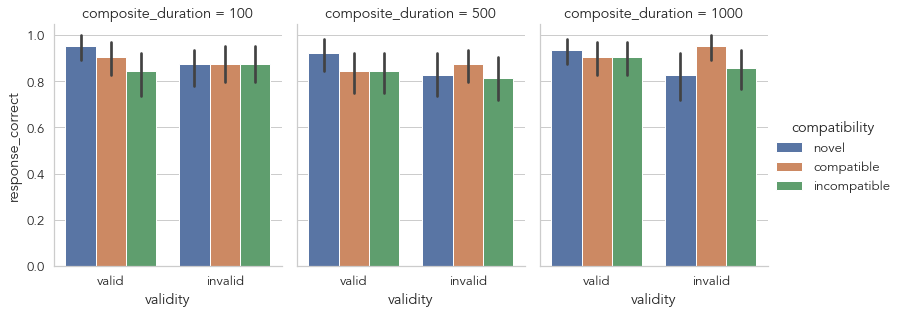

In [806]:
# Are people more accurate in compatible trials?

g = sns.catplot(col="composite_duration", 
                x="validity",
                y="response_correct", 
                hue="compatibility",
                hue_order=['novel','compatible','incompatible'],
                dodge=True,
                kind="bar",
                data=df_zip,
                height=4.6,
                aspect=0.8)

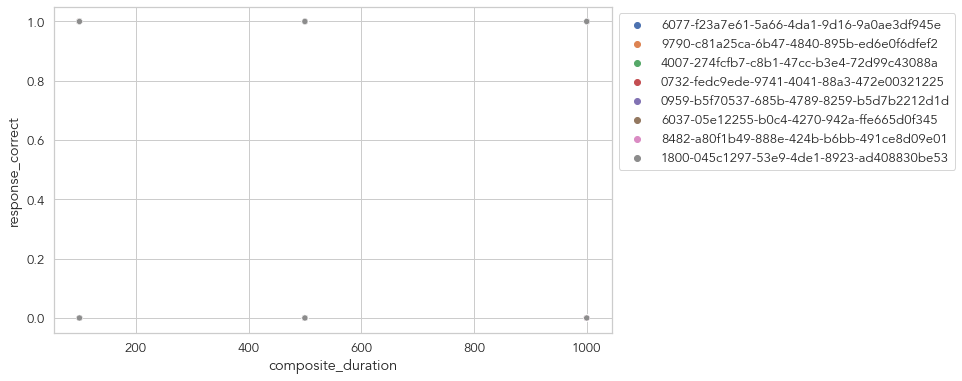

In [808]:
fig = plt.figure(figsize=(10,6))

sns.scatterplot(data=df_zip, 
              y="response_correct",
              x="composite_duration",
              hue="gameID")
plt.legend(bbox_to_anchor=(1.0,1))

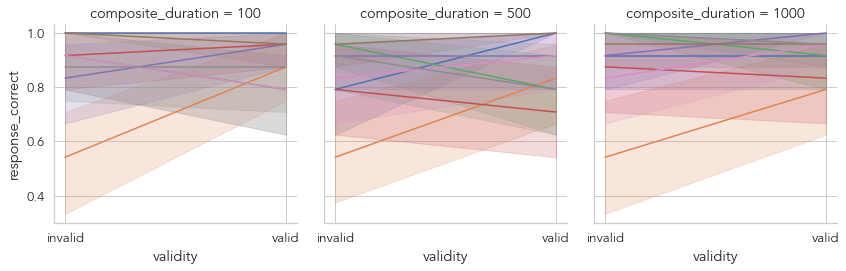

In [800]:
g = sns.FacetGrid(df_zip, col="composite_duration", height=4, hue='gameID')
g.map(sns.lineplot, "validity", "response_correct");

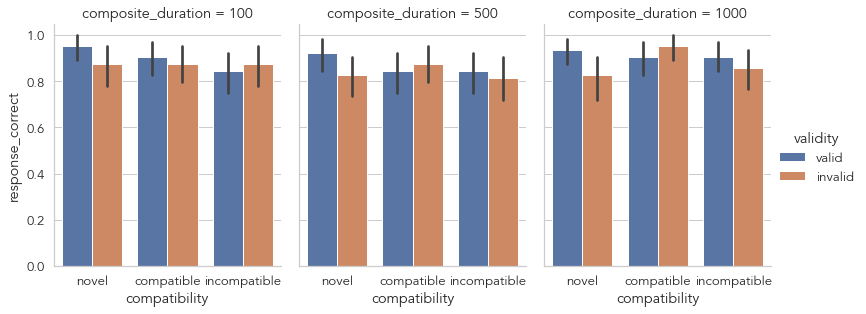

In [746]:
# Are people more accurate in compatible trials? same as above

g = sns.catplot(col="composite_duration", 
                hue="validity",
                y="response_correct", 
                x="compatibility",
                order=['novel','compatible','incompatible'],
                dodge=True,
                kind="bar",
                data=df_zip,
                height=4.6,
                aspect=0.8)

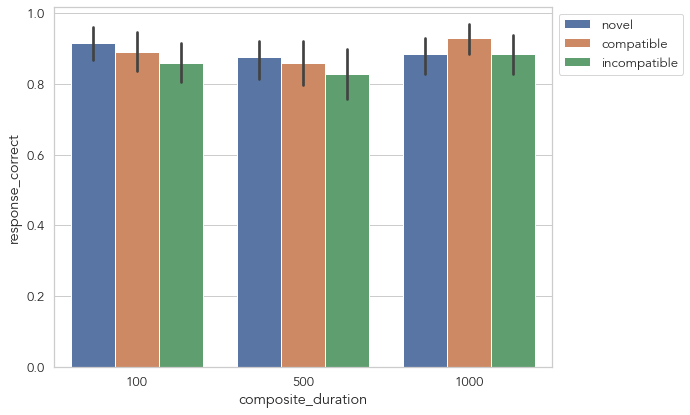

In [747]:
# Are people more accurate in compatible trials?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "response_correct",
                x = "composite_duration",
                hue= "compatibility", 
                hue_order=['novel','compatible','incompatible'])

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.0,1))

### RT

/Users/will/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/will/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rt', ylabel='Density'>

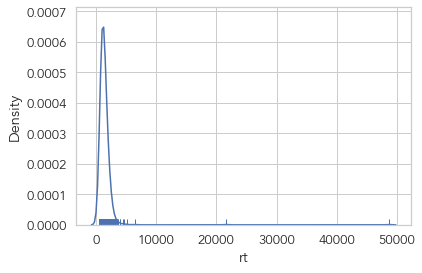

In [748]:
# sns.distplot(data=df_zip, y='rt', x="trial_index")
sns.distplot(df_zip.rt, rug=True, hist=False)

<AxesSubplot:xlabel='rt', ylabel='Count'>

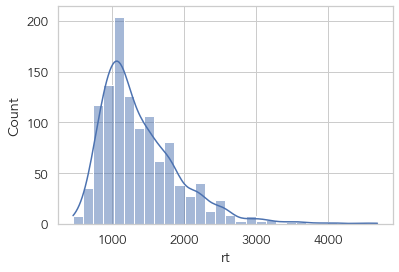

In [749]:
# sns.distplot(df_zip[(~df_zip.flagRT)].rt, rug=True, hist=False)

sns.histplot(data=df_zip[(~df_zip.flagRT)], x="rt", bins=30, kde=True)

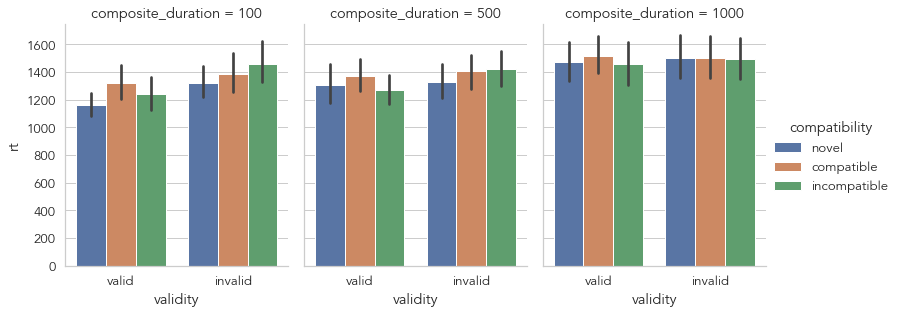

In [750]:
# Are people faster in compatible trials?

g = sns.catplot(col="composite_duration", 
                x="validity",
                y="rt", 
                hue="compatibility",
                hue_order=['novel','compatible','incompatible'],
                dodge=True,
                kind="bar",
                data=df_zip[~df_zip.flagRT],
                height=4.6,
                aspect=0.8)

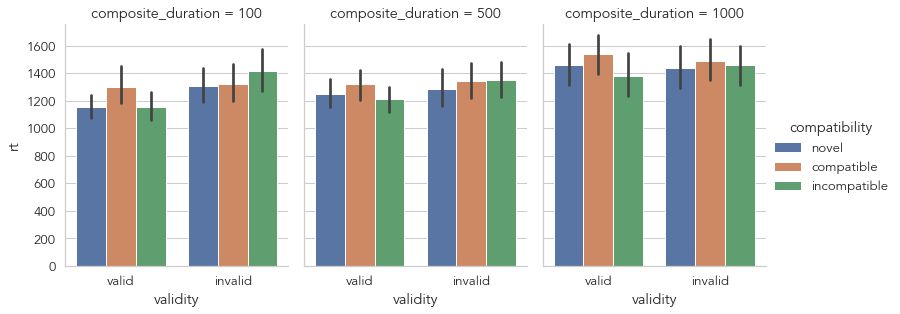

In [751]:
# correct responses only
# Are people faster in compatible trials

g = sns.catplot(col="composite_duration", 
                x="validity",
                y="rt", 
                hue="compatibility",
                hue_order=['novel','compatible','incompatible'],
                dodge=True,
                kind="bar",
                data=df_zip[(~df_zip.flagRT) & (df_zip.response_correct)],
                height=4.6,
                aspect=0.8)

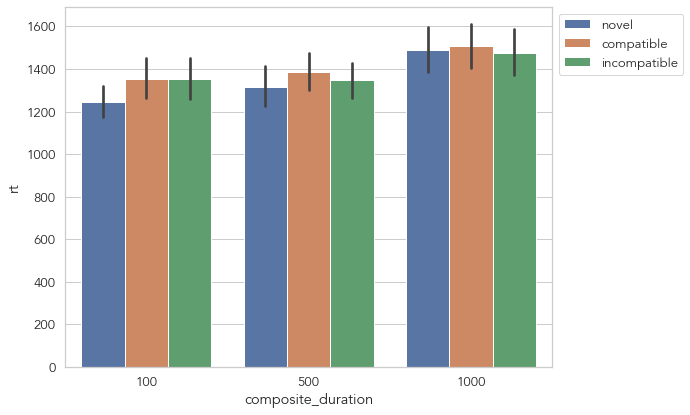

In [752]:
# Are people faster in compatible trials?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip[~df_zip.flagRT], 
                y= "rt",
                x = "composite_duration",
                hue= "compatibility", hue_order=['novel','compatible','incompatible'])

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.0,1))

In [753]:
df_zip

,index,_id,rt,stimulus,response,response_correct,stimURL,chunk_id,rep,block_number,...,internal_node_id,datatype,experimentName,iterationName,workerID,gameID,compatibility,composite_id,trial_bin,flagRT
0,0,61678fd99075de37027a1f43,2155.4,https://tower-4-block-unique-silhouettes-compo...,m,1,https://tower-4-block-unique-silhouettes-compo...,wides_025_023,0,0,...,0.0-21.0,trial_end,block_construction_zipping,pilot_0,61678071de3b5fb66dd56f43,6077-f23a7e61-5a66-4da1-9d16-9a0ae3df945e,novel,talls_100_118.png,2.0,False
1,1,61678fdc9075de37027a1f44,993.8,https://tower-4-block-unique-silhouettes-compo...,z,1,https://tower-4-block-unique-silhouettes-compo...,wides_025_023,0,0,...,0.0-22.0,trial_end,block_construction_zipping,pilot_0,61678071de3b5fb66dd56f43,6077-f23a7e61-5a66-4da1-9d16-9a0ae3df945e,novel,talls_100_118.png,2.0,False
2,2,61678fe09075de37027a1f45,1558.3,https://tower-4-block-unique-silhouettes-compo...,m,1,https://tower-4-block-unique-silhouettes-compo...,wides_025_023,0,0,...,0.0-23.0,trial_end,block_construction_zipping,pilot_0,61678071de3b5fb66dd56f43,6077-f23a7e61-5a66-4da1-9d16-9a0ae3df945e,incompatible,talls_122_127.png,2.0,False
3,3,61678fe29075de37027a1f46,989.6,https://tower-4-block-unique-silhouettes-compo...,z,1,https://tower-4-block-unique-silhouettes-compo...,wides_025_023,0,0,...,0.0-24.0,trial_end,block_construction_zipping,pilot_0,61678071de3b5fb66dd56f43,6077-f23a7e61-5a66-4da1-9d16-9a0ae3df945e,novel,talls_100_118.png,2.0,False
4,4,61678fe59075de37027a1f47,983.6,https://tower-4-block-unique-silhouettes-compo...,m,0,https://tower-4-block-unique-silhouettes-compo...,wides_025_023,0,0,...,0.0-25.0,trial_end,block_construction_zipping,pilot_0,61678071de3b5fb66dd56f43,6077-f23a7e61-5a66-4da1-9d16-9a0ae3df945e,incompatible,talls_122_127.png,2.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,1435,6168995820153c3569ff005b,1600.5,https://tower-4-block-unique-silhouettes-compo...,z,1,https://tower-4-block-unique-silhouettes-compo...,wides_025_023,3,2,...,0.0-164.0,trial_end,block_construction_zipping,pilot_0,615375a2fd9b41728babd98a,1800-045c1297-53e9-4de1-8923-ad408830be53,incompatible,talls_102_126.png,14.0,False
1148,1436,6168995c20153c3569ff005c,1513.9,https://tower-4-block-unique-silhouettes-compo...,m,1,https://tower-4-block-unique-silhouettes-compo...,wides_025_023,3,2,...,0.0-165.0,trial_end,block_construction_zipping,pilot_0,615375a2fd9b41728babd98a,1800-045c1297-53e9-4de1-8923-ad408830be53,incompatible,talls_122_127.png,14.0,False
1149,1437,6168996020153c3569ff005d,1524.9,https://tower-4-block-unique-silhouettes-compo...,z,1,https://tower-4-block-unique-silhouettes-compo...,wides_025_023,3,2,...,0.0-166.0,trial_end,block_construction_zipping,pilot_0,615375a2fd9b41728babd98a,1800-045c1297-53e9-4de1-8923-ad408830be53,novel,talls_100_118.png,14.0,False
1150,1438,6168996420153c3569ff005e,1742.7,https://tower-4-block-unique-silhouettes-compo...,z,1,https://tower-4-block-unique-silhouettes-compo...,wides_025_023,3,2,...,0.0-167.0,trial_end,block_construction_zipping,pilot_0,615375a2fd9b41728babd98a,1800-045c1297-53e9-4de1-8923-ad408830be53,compatible,talls_122_127.png,14.0,False


### Duration

<AxesSubplot:xlabel='composite_duration', ylabel='response_correct'>

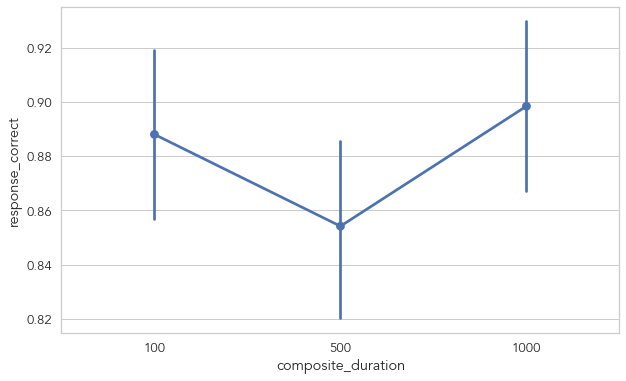

In [754]:
fig = plt.figure(figsize=(10,6))
sns.pointplot(data=df_zip, 
              y="response_correct", 
              x="composite_duration")

<AxesSubplot:xlabel='composite_duration', ylabel='rt'>

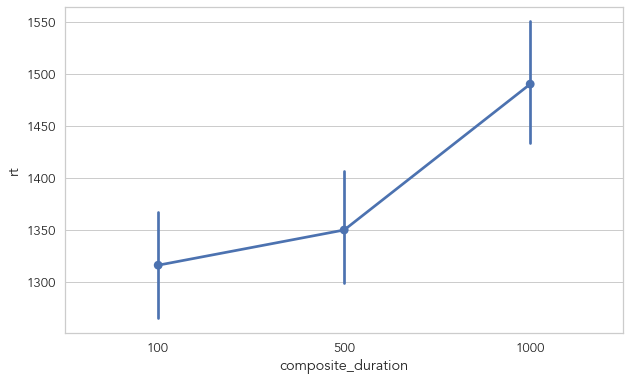

In [756]:
# How often were most popular chunks built by left-out ppt, by phase, by structure?

fig = plt.figure(figsize=(10,6))

sns.pointplot(data=df_zip[~df_zip.flagRT], 
              y="rt", 
              x="composite_duration")
# g = sns.FacetGrid(df, col="", height=4, hue='')
# g.map(sns.pointplot, "response_correct", "composite_duration", order=['pre','post']);

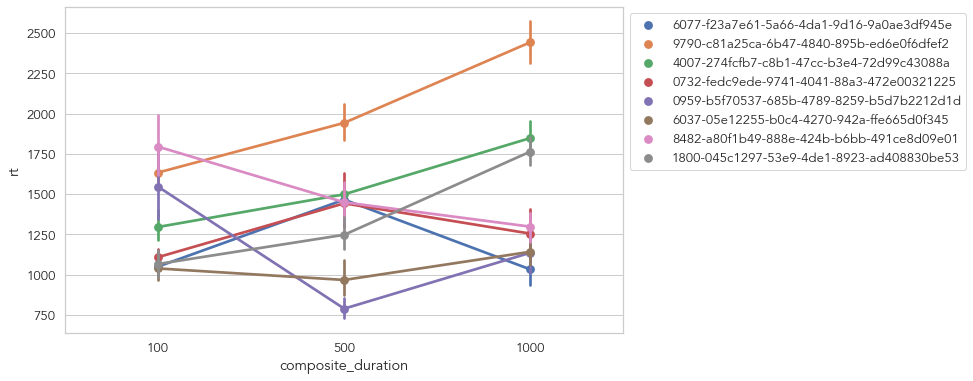

In [757]:
# How often were most popular chunks built by left-out ppt, by phase, by structure?

fig = plt.figure(figsize=(10,6))

sns.pointplot(data=df_zip[~df_zip.flagRT], 
              y="rt", 
              x="composite_duration",
              hue="gameID")
plt.legend(bbox_to_anchor=(1.0,1))
# g = sns.FacetGrid(df, col="", height=4, hue='')
# g.map(sns.pointplot, "response_correct", "composite_duration", order=['pre','post']);

### Time

<Figure size 1008x144 with 0 Axes>

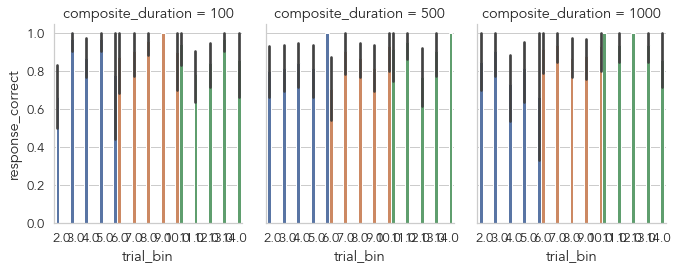

In [758]:
fig = plt.figure(figsize=(14,2))
g = sns.catplot(col="composite_duration", 
                x="trial_bin",
                y="response_correct", 
                hue="block_number", 
                dodge=True,
                kind="bar",
                data=df_zip,
                height=4, 
                aspect=0.8)

# (g.set_axis_labels("")
#   .set_xticklabels(["first", "final"])
#   .set(ylim=(0,0.6)))
#   .set(xlim=(-0.6,1.6)))

g._legend.remove()

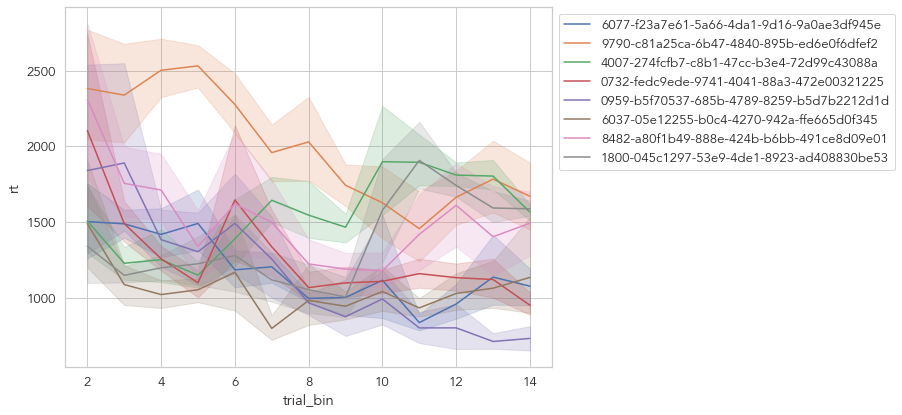

In [759]:
fig = plt.figure(figsize=(8,6))

c = sns.lineplot(data=df_zip[~df_zip.flagRT], 
                y= "rt",
                x = "trial_bin",
                hue= "gameID")

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.0,1))

### Validity

Looks like valid trials might be a little easier

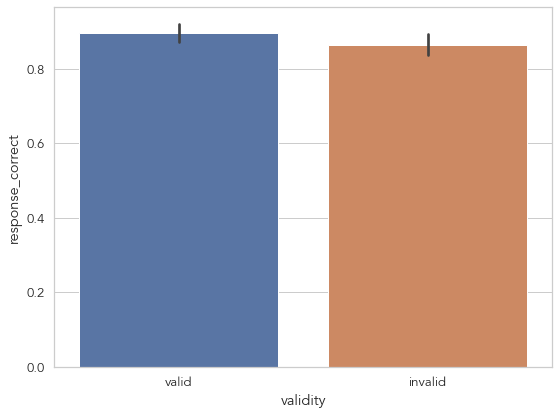

In [760]:
# are valid trials more accurate?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "response_correct", 
                x="validity"
                )

plt.tight_layout()

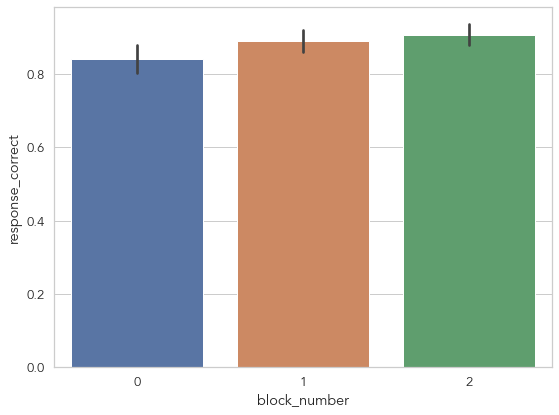

In [801]:
# are valid trials more accurate?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "response_correct", 
#                 hue="validity",
                x = "block_number"
                )

plt.tight_layout()

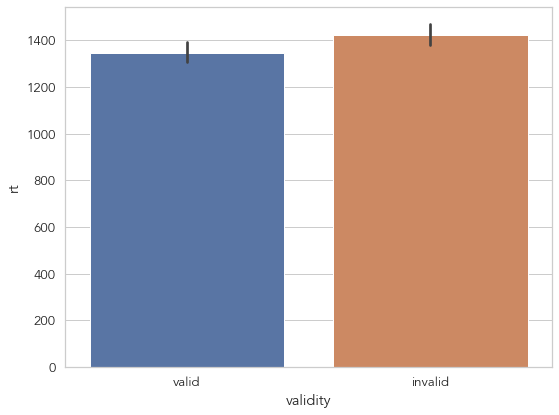

In [762]:
# are valid trials faster?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip[~df_zip.flagRT], 
                y= "rt", 
                x="validity")

plt.tight_layout()

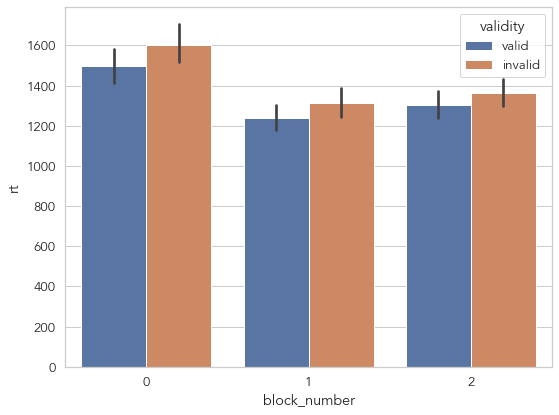

In [763]:
# are valid trials faster?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip[~df_zip.flagRT], 
                y= "rt", 
                hue="validity",
                x="block_number")

plt.tight_layout()

### Part type (tall vs. wide)

Looks like wide might be a little easier

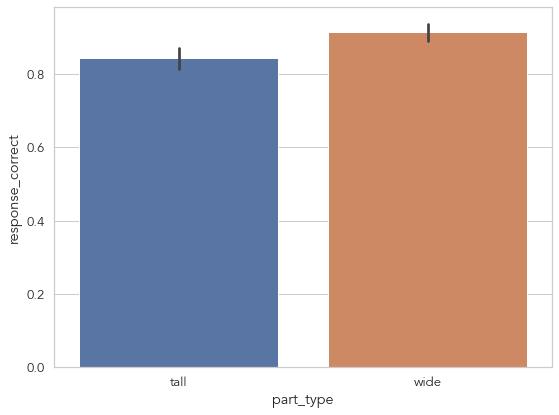

In [764]:
# Is either part type easier- accuracy?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "response_correct", 
                x="part_type")

plt.tight_layout()

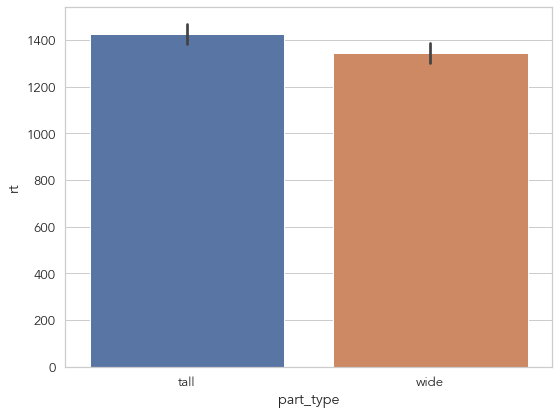

In [765]:
# Is either part type easier- rt?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip[~df_zip.flagRT], 
                y= "rt", 
                x="part_type")

plt.tight_layout()

### Condition (A vs. B)

Is one condition easier than the others?
A looks a bit easier.

In [766]:
# how many people in each condition
df_zip.groupby('gameID').first().value_counts('participant_condition')

participant_condition
A    5
B    3
dtype: int64

#### Participant condition

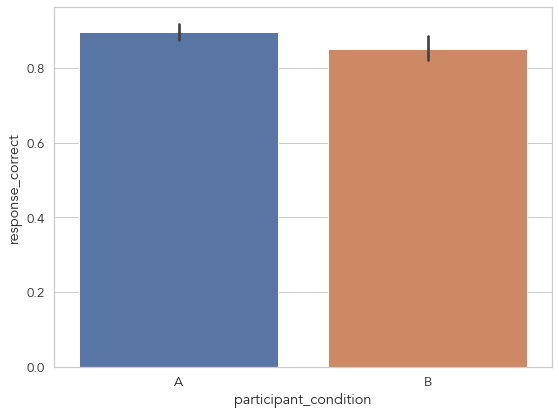

In [767]:
# Is either part type easier- accuracy?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "response_correct", 
                x= "participant_condition")

plt.tight_layout()

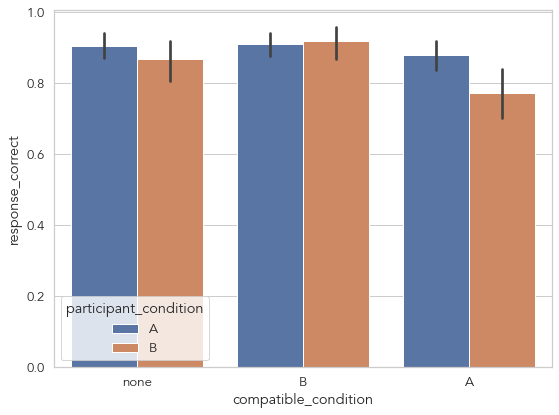

In [768]:
# break down by 

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "response_correct", 
                x= "compatible_condition",
                hue="participant_condition")

plt.tight_layout()

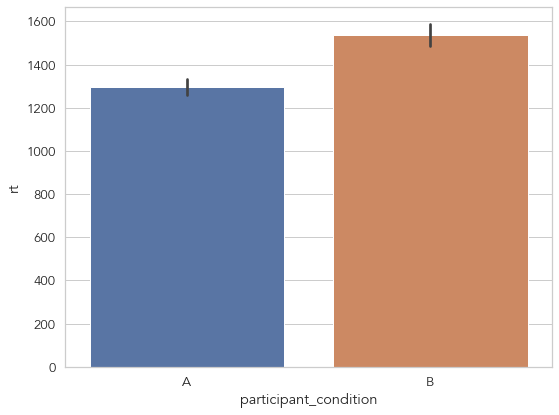

In [769]:
# Is either part type easier- rt?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip[~df_zip.flagRT], 
                y= "rt", 
                x= "participant_condition")

plt.tight_layout()

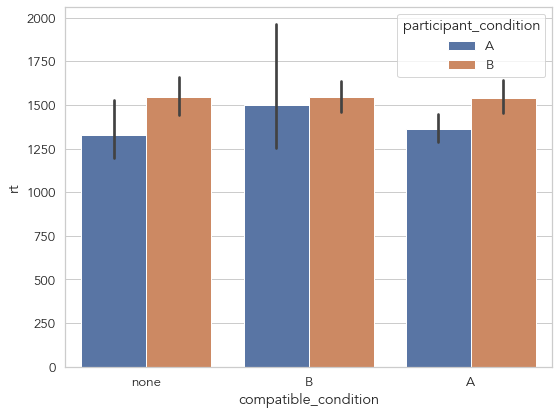

In [770]:
# Is either part type easier- accuracy?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "rt", 
                x= "compatible_condition",
                hue="participant_condition")

plt.tight_layout()

### Stimuli

Are some stims easier than others?

In [771]:
stim_order = ['https://tower-4-block-unique-silhouettes-composite-silhouette-png.s3.amazonaws.com/tower_4_block_unique_silhouette_composites_silhouette_talls_100_118.png',
       'https://tower-4-block-unique-silhouettes-composite-silhouette-png.s3.amazonaws.com/tower_4_block_unique_silhouette_composites_silhouette_talls_122_127.png',
       'https://tower-4-block-unique-silhouettes-composite-silhouette-png.s3.amazonaws.com/tower_4_block_unique_silhouette_composites_silhouette_talls_102_126.png']

In [772]:
composite_id_order = [url.split('composites_silhouette_')[1] for url in stim_order]
composite_id_order

['talls_100_118.png', 'talls_122_127.png', 'talls_102_126.png']

In [773]:
img(url=stim_order[0])

In [774]:
img(url=stim_order[1])

In [775]:
img(url=stim_order[2])

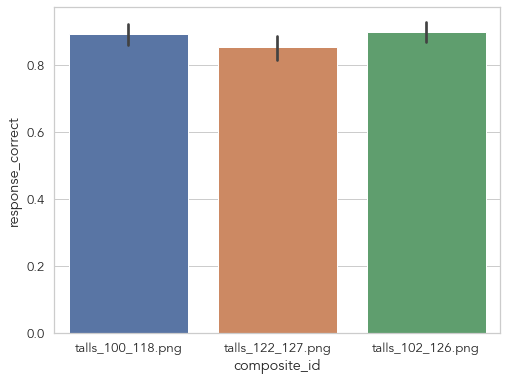

In [776]:
# Is either part type easier- accuracy?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "response_correct", 
                x= "composite_id",
                order= composite_id_order)


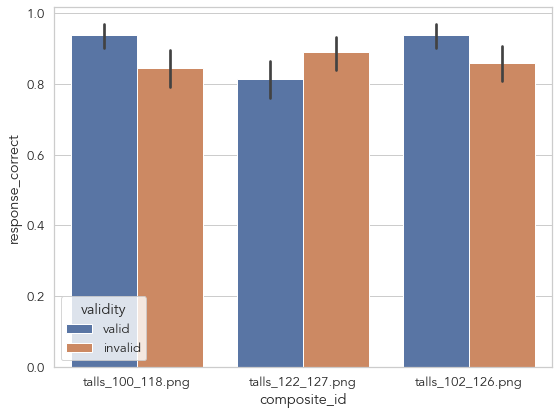

In [777]:
# Is either part type easier at saying one particular way?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip, 
                y= "response_correct", 
                x= "composite_id",
                order = composite_id_order,
                hue="validity")

plt.tight_layout()

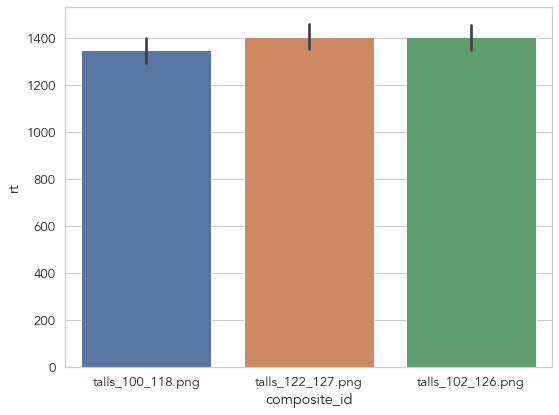

In [778]:
# Is either part type easier- rt?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip[~df_zip.flagRT], 
                y= "rt", 
                x= "composite_id",
               order = composite_id_order)

plt.tight_layout()

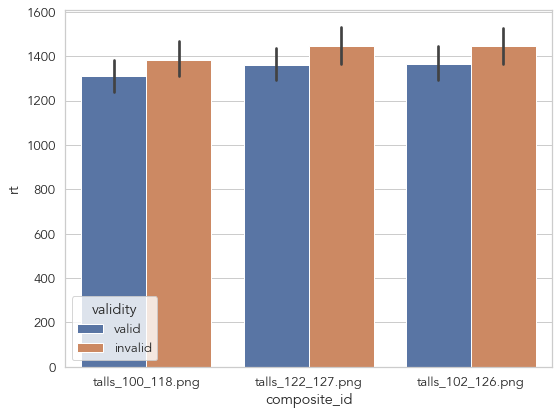

In [779]:
# Is either part type easier at saying one particular way- rt?

fig = plt.figure(figsize=(8,6))

c = sns.barplot(data=df_zip[~df_zip.flagRT], 
                y= "rt", 
                x= "composite_id",
                order = composite_id_order,
                hue="validity")

plt.tight_layout()

In [780]:
df_zip.columns

Index(['index', '_id', 'rt', 'stimulus', 'response', 'response_correct',
       'stimURL', 'chunk_id', 'rep', 'block_number', 'composite_duration',
       'chunk_duration', 'participant_condition', 'compatible_trial',
       'validity', 'talls_name', 'wides_name', 'part_type', 'part_a', 'part_b',
       'compatible_condition', 'trial_type', 'trial_index', 'time_elapsed',
       'internal_node_id', 'datatype', 'experimentName', 'iterationName',
       'workerID', 'gameID', 'compatibility', 'composite_id', 'trial_bin',
       'flagRT'],
      dtype='object')

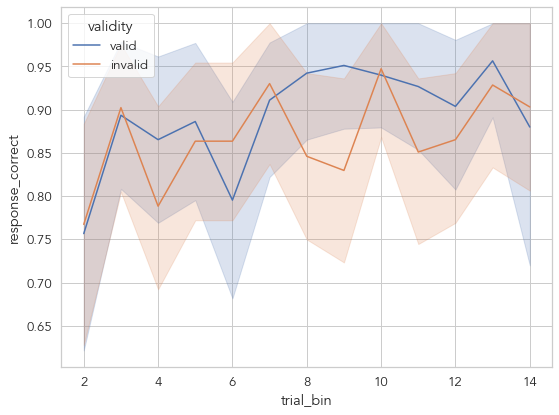

In [781]:
# Is either part type easier at saying one particular way?

fig = plt.figure(figsize=(8,6))

c = sns.lineplot(data=df_zip, 
                y= "response_correct", 
                x= "trial_bin",
                hue="validity")

plt.tight_layout()

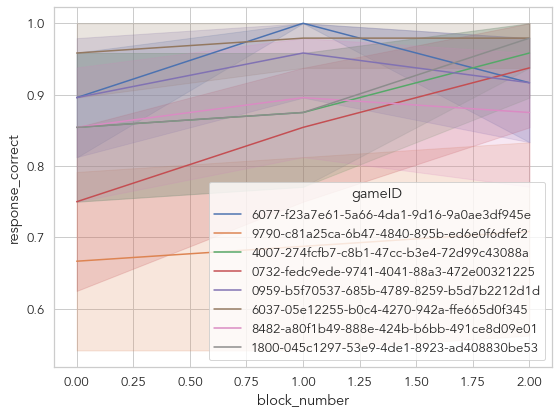

In [786]:
# Is either part type easier at saying one particular way?

fig = plt.figure(figsize=(8,6))

c = sns.lineplot(data=df_zip, 
                y= "response_correct", 
                x= "block_number",
                hue="gameID")

plt.tight_layout()